In [2]:
import pandas as pd
import tensorflow as tf
from pathlib import Path
from defi_lend_eval.modelling import contract
from defi_lend_eval.preprocess.contract import pre_process

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
p = Path('data/')
# fnames = contract.find_data_file(p, '_matrix.csv')
# df = contract.read_data(fnames)
df = pre_process(p)
df = df.dropna()
display(df.shape)
df.head()

2021-11-13 20:37:40.698 | INFO     | defi_lend_eval.preprocess.contract:pre_process:190 - Start reading matrix.csv...
2021-11-13 20:37:40.925 | INFO     | defi_lend_eval.preprocess.contract:pre_process:196 - Start reading commits.json...
2021-11-13 20:39:53.493 | INFO     | defi_lend_eval.preprocess.contract:pre_process:203 - Data pre-processing...


(19482, 18)

,commit,la,ld,ns,nd,nf,ent,nuc,ndev,inter,exp,rexp,sexp,pod,fix,buggy,nw,nfunc
0,ca96d695,966,37,3,7,14,1.332095,62,1,64.008765,210,0.029312,188,1.000000,False,False,4081,29
1,1d02a6bb,7,7,3,4,5,1.220036,29,1,294.411611,117,0.004706,44,1.000000,False,False,334,0
2,33639778,24751,115,2,3,44,1.089848,39,2,569.835787,91,0.020129,26,0.487179,False,True,528435,3435
3,2383726a,3,1,1,1,1,0.026486,59,1,118.513333,152,0.402389,104,1.000000,True,False,70,0
4,d01b89b9,31,19,3,3,11,3.046779,10,1,16.237778,77,0.006936,26,1.000000,True,False,1150,0


In [3]:
fnames = contract.find_data_file(p, 'commits.json')
used_df = contract.read_data(fnames, 'json')
used_df = used_df.dropna()
used_df.head()

,commit,msg,changes,buggy,plat
0,f57cf8a6,Add storage gaps to Rescuable and Sponsorable,diff --git a/contracts/libs/Rescuable.sol b/co...,False,88mph_buggy_commits
1,0a0c5a83,Fixed best practices 10,diff --git a/contracts/DInterest.sol b/contrac...,True,88mph_buggy_commits
2,b5b618bc,Update deploy scripts for money markets & Dump...,diff --git a/contracts/mocks/VaultMock.sol b/c...,False,88mph_buggy_commits
3,005cb00a,Refactor test dependencies,diff --git a/test/DInterest.test.js b/test/DIn...,False,88mph_buggy_commits
4,2fdfecf9,Fix ERC20Wrapper::_transfer(),diff --git a/contracts/libs/ERC20Wrapper.sol b...,False,88mph_buggy_commits


In [4]:
used_df = used_df.drop(['plat'], axis=1)
used_df.head()


,commit,msg,changes,buggy
0,f57cf8a6,Add storage gaps to Rescuable and Sponsorable,diff --git a/contracts/libs/Rescuable.sol b/co...,False
1,0a0c5a83,Fixed best practices 10,diff --git a/contracts/DInterest.sol b/contrac...,True
2,b5b618bc,Update deploy scripts for money markets & Dump...,diff --git a/contracts/mocks/VaultMock.sol b/c...,False
3,005cb00a,Refactor test dependencies,diff --git a/test/DInterest.test.js b/test/DIn...,False
4,2fdfecf9,Fix ERC20Wrapper::_transfer(),diff --git a/contracts/libs/ERC20Wrapper.sol b...,False


In [5]:
used_df = used_df[['commit', 'changes', 'buggy']]
used_df['changes'] = used_df['changes'].apply(lambda x:pre_process_data(x))
used_df.dropna(inplace=True)
display(used_df.shape)
used_df.head()

(19392, 3)

,commit,changes,buggy
0,f57cf8a6,+\n+ uint256[50] private __gap;\n+\n+ ui...,False
1,0a0c5a83,"+ uint256 _UIRMultiplier, // Upfront in...",True
2,b5b618bc,+\n+ function pricePerShare() external view...,False
3,005cb00a,+const Base = require('./base')\n+ const INIT...,False
4,2fdfecf9,+ parentMultitoken.wrapperTransfer(send...,False


In [6]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def lower_case(txt):
    """ turn all letters into lower case """
    return str(txt).lower()

def rm_special_words(txt):
    """ remove all sepcial words """
    # remove special charaecters
    txt = re.sub(r'[\!\#\$\%\&\(\)\*+\,\-\.\/\;\:\<\=\>\?\@\[\]\\\^\_\`\{\}\|\~\n]', ' ', txt)
    # replace number and string literals with sepcial tokens
    txt = re.sub(r"([\d ]+)", " <NUM> ", txt)
    txt = re.sub(r"(\".*?\")", " <STR> ", txt)
    txt = re.sub(r"(\'.*?\')", " <STR> ", txt)
    return txt
    
def filter_words(words):
    """ remove punctuations and stopwords """
    stops = stopwords.words("english")
    words = [w for w in words if (w.isalpha() and w not in stops)]
    return words
    
def stem_words(words):
    """ perform words stemming """
    snowball = SnowballStemmer("english")
    words = [snowball.stem(w) for w in words]
    return words
    
def preprocess(txt):
    """ required preprocessing """
    # txt = lower_case(txt)
    txt = rm_special_words(txt)
    return txt

In [7]:
used_df['words'] = used_df['changes'].apply(lambda x : preprocess(x))
used_df.head()

,commit,changes,buggy,words
0,f57cf8a6,+\n+ uint256[50] private __gap;\n+\n+ ui...,False,<NUM> uint <NUM> private <NUM> gap <NUM> uint...
1,0a0c5a83,"+ uint256 _UIRMultiplier, // Upfront in...",True,<NUM> uint <NUM> UIRMultiplier <NUM> Upfront ...
2,b5b618bc,+\n+ function pricePerShare() external view...,False,<NUM> function <NUM> pricePerShare <NUM> exte...
3,005cb00a,+const Base = require('./base')\n+ const INIT...,False,<NUM> const <NUM> Base <NUM> require <NUM> <...
4,2fdfecf9,+ parentMultitoken.wrapperTransfer(send...,False,<NUM> parentMultitoken <NUM> wrapperTransfer ...


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv_fit = cv.fit_transform(used_df['words'].tolist())

In [9]:
display(len(cv.get_feature_names()))
used_df['nw'] = cv_fit.toarray().sum(axis=1)
used_df.head()

118263

,commit,changes,buggy,words,nw
0,f57cf8a6,+\n+ uint256[50] private __gap;\n+\n+ ui...,False,<NUM> uint <NUM> private <NUM> gap <NUM> uint...,13
1,0a0c5a83,"+ uint256 _UIRMultiplier, // Upfront in...",True,<NUM> uint <NUM> UIRMultiplier <NUM> Upfront ...,205
2,b5b618bc,+\n+ function pricePerShare() external view...,False,<NUM> function <NUM> pricePerShare <NUM> exte...,839
3,005cb00a,+const Base = require('./base')\n+ const INIT...,False,<NUM> const <NUM> Base <NUM> require <NUM> <...,5087
4,2fdfecf9,+ parentMultitoken.wrapperTransfer(send...,False,<NUM> parentMultitoken <NUM> wrapperTransfer ...,13


In [10]:
idx = cv.get_feature_names().index('function')
used_df['nfunc'] = cv_fit.toarray()[:,idx]
used_df.head()

,commit,changes,buggy,words,nw,nfunc
0,f57cf8a6,+\n+ uint256[50] private __gap;\n+\n+ ui...,False,<NUM> uint <NUM> private <NUM> gap <NUM> uint...,13,0
1,0a0c5a83,"+ uint256 _UIRMultiplier, // Upfront in...",True,<NUM> uint <NUM> UIRMultiplier <NUM> Upfront ...,205,0
2,b5b618bc,+\n+ function pricePerShare() external view...,False,<NUM> function <NUM> pricePerShare <NUM> exte...,839,5
3,005cb00a,+const Base = require('./base')\n+ const INIT...,False,<NUM> const <NUM> Base <NUM> require <NUM> <...,5087,0
4,2fdfecf9,+ parentMultitoken.wrapperTransfer(send...,False,<NUM> parentMultitoken <NUM> wrapperTransfer ...,13,0


In [11]:
df = pd.merge(df, used_df, on=['commit','buggy'])
df.drop(['changes', 'plat', 'words'], axis=1, inplace=True)
df.head()

,commit,la,ld,ns,nd,nf,ent,nuc,ndev,inter,exp,rexp,sexp,pod,fix,buggy,nw,nfunc
0,ca96d695,966,37,3,7,14,1.332095,62,1,64.008765,210,0.029312,188,1.000000,False,False,3612,29
1,1d02a6bb,7,7,3,4,5,1.220036,29,1,294.411611,117,0.004706,44,1.000000,False,False,25,0
2,33639778,24751,115,2,3,44,1.089848,39,2,569.835787,91,0.020129,26,0.487179,False,True,95,0
3,2383726a,3,1,1,1,1,0.026486,59,1,118.513333,152,0.402389,104,1.000000,True,False,15,0
4,d01b89b9,31,19,3,3,11,3.046779,10,1,16.237778,77,0.006936,26,1.000000,True,False,271,0


In [12]:
# remove commit with too many added lines, since those changes may mainly due to
# the modification of configurations files (like json, yaml, and so on.)
# q99 = df['la'].quantile(0.995)
# display(q99)
# df = df[df['la'] < q99]
# display(df.shape)

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=28)
display(test['buggy'].value_counts())
display(train['buggy'].value_counts())

False    5463
True      382
Name: buggy, dtype: int64

False    12766
True       871
Name: buggy, dtype: int64

In [5]:
train_x = train.drop(['commit', 'buggy'], axis=1)
train_y = train['buggy']
display(train_x)
train_y

,la,ld,ns,nd,nf,ent,nuc,ndev,inter,exp,rexp,sexp,pod,fix,nw,nfunc
1235,7,0,1,1,1,0.464386,9,3,5.821667,22,0.048633,16,0.000000,False,107,0
11044,63,4,1,1,2,0.478223,38,6,1.226667,32,0.019554,22,0.184211,False,827,0
14910,17,9,8,8,8,1.851868,26,4,0.042222,451,1.067220,191,0.576923,False,374,0
15300,1,1,1,1,1,0.013453,3,3,522.352500,0,0.000000,0,0.000000,True,106,0
8367,158,10,2,2,2,0.258672,104,5,141.811944,869,0.003806,535,0.942308,True,1541,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16471,6,3,1,1,1,0.370989,1,2,26.853056,422,0.008943,126,0.000000,True,136,0
7427,39,4,1,2,2,0.744302,23,2,17.378333,45,0.199736,26,0.391304,False,838,0
7200,3897,2,1,1,1,0.437606,340,14,172.863056,11,0.446245,4,0.002941,False,37714,0
4089,64,8,1,1,2,0.134793,142,4,0.300833,173,0.003357,84,0.521127,False,437,0


1235     False
11044    False
14910    False
15300    False
8367     False
         ...  
16471    False
7427     False
7200     False
4089     False
9473     False
Name: buggy, Length: 13637, dtype: bool

In [6]:
from imblearn.over_sampling import SMOTE

x_resampled, y_resampled = SMOTE(random_state=131).fit_resample(train_x, train_y)
display(x_resampled.shape)
display(x_resampled)
display(y_resampled.shape)
display(y_resampled)
display(y_resampled.value_counts())

(25532, 16)

,la,ld,ns,nd,nf,ent,nuc,ndev,inter,exp,rexp,sexp,pod,fix,nw,nfunc
0,7,0,1,1,1,0.464386,9,3,5.821667,22,0.048633,16,0.000000,False,107,0
1,63,4,1,1,2,0.478223,38,6,1.226667,32,0.019554,22,0.184211,False,827,0
2,17,9,8,8,8,1.851868,26,4,0.042222,451,1.067220,191,0.576923,False,374,0
3,1,1,1,1,1,0.013453,3,3,522.352500,0,0.000000,0,0.000000,True,106,0
4,158,10,2,2,2,0.258672,104,5,141.811944,869,0.003806,535,0.942308,True,1541,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25527,14,21,2,6,10,0.602395,111,6,356.607858,76,0.004467,69,0.314486,False,1166,0
25528,36,2,1,2,2,0.327207,24,3,15.830052,61,0.254678,53,0.415441,True,324,0
25529,3,4,2,2,2,0.524754,10,1,3.139849,11,0.394485,8,1.000000,False,202,0
25530,171,18,1,2,4,0.430422,316,7,440.122567,377,0.063962,216,0.311860,False,1079,0


(25532,)

0        False
1        False
2        False
3        False
4        False
         ...  
25527     True
25528     True
25529     True
25530     True
25531     True
Name: buggy, Length: 25532, dtype: bool

True     12766
False    12766
Name: buggy, dtype: int64

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

rf = RandomForestClassifier(n_estimators=300, random_state=28, criterion='entropy', max_features=5)
rf.fit(x_resampled, y_resampled)
# rf.fit(StandardScaler().fit_transform(x_resampled), y_resampled

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=300,
                       random_state=28)

In [8]:
test_x = test.drop(['commit', 'buggy'], axis=1)
test_y = test['buggy']

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score

predictions = rf.predict(test_x)
report = classification_report(test_y, predictions)
unique_label = np.unique([test_y, predictions])
cmtx = pd.DataFrame(
    confusion_matrix(test_y, predictions, labels=unique_label), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label]
)
print(report)
print(cmtx)

              precision    recall  f1-score   support

       False       0.96      0.93      0.94      5463
        True       0.29      0.41      0.34       382

    accuracy                           0.89      5845
   macro avg       0.62      0.67      0.64      5845
weighted avg       0.91      0.89      0.90      5845

            pred:False  pred:True
true:False        5067        396
true:True          224        158


In [10]:
pred_prob = rf.predict_proba(test_x)

max_score = 0
th = 0

for i in range(1, 100):
    pred2 = (pred_prob[:,1] >= i/100)
    score = f1_score(test_y, pred2)
    if score > max_score:
        max_score = score
        th = i/100

print(f'Threshhold: {th}; Max-Score: {max_score}')
pred2 = (pred_prob[:,1] >= 0.43)
rep2 = classification_report(test_y, pred2)
print(rep2)
print(confusion_matrix(test_y, pred2))

Threshhold: 0.54; Max-Score: 0.34953703703703703
              precision    recall  f1-score   support

       False       0.96      0.90      0.93      5463
        True       0.25      0.51      0.34       382

    accuracy                           0.87      5845
   macro avg       0.61      0.70      0.63      5845
weighted avg       0.92      0.87      0.89      5845

[[4892  571]
 [ 187  195]]


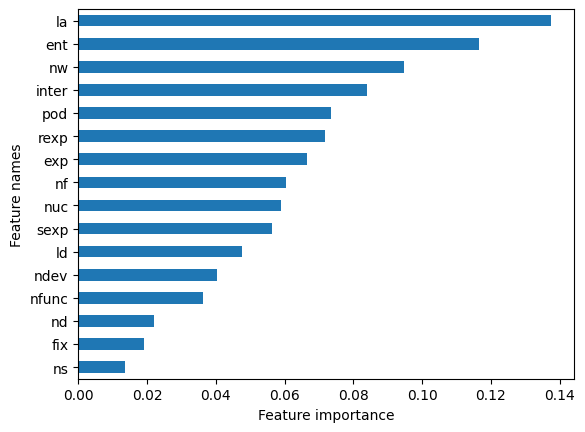

In [20]:
from matplotlib import pyplot as plt
feat_importances = pd.Series(rf.feature_importances_, index=train_x.columns)
feat_importances.nsmallest(18).plot(kind='barh')
plt.xlabel('Feature importance')
plt.ylabel('Feature names')
plt.show()

In [21]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(rf.estimators_[10], 
                out_file='tree.dot', 
                feature_names = train_x.columns,
                # class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [125]:
import joblib

joblib.dump(rf, "models/random_forest.joblib")

['models/random_forest.joblib']